In [1]:
# Clone PyTorch repository for EfficientDet
!git clone -q https://github.com/zylo117/Yet-Another-EfficientDet-Pytorch.git
%cd /content/Yet-Another-EfficientDet-Pytorch

# Install dependencies
!pip install -q torch>=1.4.0 torchvision>=0.5.0 tensorboardX>=2.0 pycocotools>=2.0 tqdm>=4.43.0 pyyaml>=5.3 opencv-python

# Download pre-trained weights for transfer learning
# These weights are for the model's backbone, which speeds up training significantly
!mkdir -p weights
!wget -q https://github.com/zylo117/Yet-Another-EfficientDet-Pytorch/releases/download/1.0/efficientdet-d0.pth -O weights/efficientdet-d0.pth

# Imports for the following cells
import os
import shutil
import random
import yaml
import xml.etree.ElementTree as ET
from glob import glob
from tqdm import tqdm
import re
import pandas as pd
import matplotlib.pyplot as plt
import torch
import cv2
import numpy as np
from PIL import Image
from backbone import EfficientDetBackbone
from utils.utils import preprocess, postprocess
from efficientdet.utils import BBoxTransform, ClipBoxes


# Confirmation message
print("PyTorch environment for EfficientDet configured successfully")

/content/Yet-Another-EfficientDet-Pytorch
PyTorch environment for EfficientDet configured successfully


In [12]:
import time

In [2]:
# Download and Prepare the Dataset in the Correct Format
%cd /content/
!git clone -q https://github.com/md-121/yellow-sticky-traps-dataset

# Create the folder structure that the training script expects
# The final structure should be:
# /content/datasets/insect_project/
# ├── train/
# │   ├── image1.jpg
# │   └── ...
# └── val/
#     ├── image3.jpg
#     └── ...
# └── annotations/
#     ├── instances_train.json
#     └── instances_val.json  (in COCO format)

DATASET_PATH = '/content/datasets/insect_project'
TRAIN_IMG_PATH = os.path.join(DATASET_PATH, 'train')
VAL_IMG_PATH = os.path.join(DATASET_PATH, 'val')
ANNOTATIONS_PATH = os.path.join(DATASET_PATH, 'annotations')

os.makedirs(TRAIN_IMG_PATH, exist_ok=True)
os.makedirs(VAL_IMG_PATH, exist_ok=True)
os.makedirs(ANNOTATIONS_PATH, exist_ok=True)

# Split the original files and copy them to the new structure
SOURCE_IMAGES_DIR = '/content/yellow-sticky-traps-dataset/images'
SOURCE_ANNOTATIONS_DIR = '/content/yellow-sticky-traps-dataset/annotations'

# Get a shuffled list of all XML annotation files
xml_files = sorted(glob(os.path.join(SOURCE_ANNOTATIONS_DIR, '*.xml')))
random.shuffle(xml_files)

# Split the list into an 80% training set and a 20% validation set
split_idx = int(len(xml_files) * 0.8)
train_xmls = xml_files[:split_idx]
val_xmls = xml_files[split_idx:]

# This helper function copies the images and returns metadata for the conversion step
def move_and_get_info(xml_list, dest_img_path):
    file_info = []
    for xml_path in xml_list:
        base_name = os.path.splitext(os.path.basename(xml_path))[0]
        img_name = base_name + ".jpg"
        src_img_path = os.path.join(SOURCE_IMAGES_DIR, img_name)
        if os.path.exists(src_img_path):
            shutil.copy(src_img_path, dest_img_path)
            file_info.append({'xml': xml_path, 'img': img_name})
    return file_info

train_info = move_and_get_info(train_xmls, TRAIN_IMG_PATH)
val_info = move_and_get_info(val_xmls, VAL_IMG_PATH)
print(f"Dataset split: {len(train_info)} training, {len(val_info)} validation.")


# Convert XML (PASCAL VOC) to COCO format (JSON)
import json

CLASS_MAPPING = {'MR': 0, 'NC': 1, 'WF': 2}

def convert_voc_to_coco(file_info_list, output_json_path):
    # Initialize the top-level COCO dictionary structure
    coco_dict = {
        "images": [],
        "annotations": [],
        "categories": [
            {"id": 0, "name": "MR"},
            {"id": 1, "name": "NC"},
            {"id": 2, "name": "WF"}
        ]
    }

    img_id = 0
    ann_id = 0
    # Use tqdm for a progress bar
    for info in tqdm(file_info_list, desc=f"Converting to {os.path.basename(output_json_path)}"):
        # Image Information
        tree = ET.parse(info['xml'])
        root = tree.getroot()
        size = root.find('size')
        width = int(size.find('width').text)
        height = int(size.find('height').text)

        coco_dict['images'].append({
            'id': img_id,
            'file_name': info['img'],
            'height': height,
            'width': width
        })

        # Annotation Information
        for obj in root.findall('object'):
            class_name = obj.find('name').text
            class_id = CLASS_MAPPING[class_name]

            bndbox = obj.find('bndbox')
            xmin = float(bndbox.find('xmin').text)
            ymin = float(bndbox.find('ymin').text)
            xmax = float(bndbox.find('xmax').text)
            ymax = float(bndbox.find('ymax').text)

            # COCO format requires [x, y, width, height]
            w = xmax - xmin
            h = ymax - ymin

            coco_dict['annotations'].append({
                'id': ann_id,
                'image_id': img_id,
                'category_id': class_id,
                'bbox': [xmin, ymin, w, h],
                'area': w * h,
                'iscrowd': 0
            })
            ann_id += 1
        img_id += 1

    # Write the final dictionary to a JSON file
    with open(output_json_path, 'w') as f:
        json.dump(coco_dict, f, indent=2)

# Run the conversion for both training and validation sets
convert_voc_to_coco(train_info, os.path.join(ANNOTATIONS_PATH, 'instances_train.json'))
convert_voc_to_coco(val_info, os.path.join(ANNOTATIONS_PATH, 'instances_val.json'))

print("Conversion to COCO JSON format complete")

/content
Dataset split: 227 training, 57 validation.


Converting to instances_val.json: 100%|██████████| 57/57 [00:00<00:00, 4135.18it/s]

Conversion to COCO JSON format complete


In [3]:
# Create the Project Configuration File

# Define the parameters for the project in a dictionary
# This will be written to a YAML file for the training script to read
project_yaml_content = {
    'project_name': 'insect_project',

    'train_set': 'train',
    'val_set': 'val',

    'num_gpus': 1,

    # Standard ImageNet normalization values (RGB order)
    'mean': [0.485, 0.456, 0.406],
    'std': [0.229, 0.224, 0.225],

    # Default anchor box configurations. These define the initial sizes and
    # aspect ratios of the boxes the model uses to detect objects
    'anchors_scales': '[2**0, 2**0.5, 2**1]',
    'anchors_ratios': '[(1.0, 1.0), (1.4, 0.7), (0.7, 1.4)]',

    # The list of class names. The order must match the class IDs (MR:0, NC:1, WF:2)
    'obj_list': ['MR', 'NC', 'WF']
}

# Change directory into the repository folder to save the file in the right place
%cd /content/Yet-Another-EfficientDet-Pytorch

# Write the dictionary to a new YAML file inside the 'projects' directory
with open('projects/insect_project.yml', 'w') as f:
    yaml.dump(project_yaml_content, f, default_flow_style=False)

# Confirmation message
print("Configuration file 'insect_project.yml' created successfully")
!cat projects/insect_project.yml

/content/Yet-Another-EfficientDet-Pytorch
Configuration file 'insect_project.yml' created successfully
anchors_ratios: '[(1.0, 1.0), (1.4, 0.7), (0.7, 1.4)]'
anchors_scales: '[2**0, 2**0.5, 2**1]'
mean:
- 0.485
- 0.456
- 0.406
num_gpus: 1
obj_list:
- MR
- NC
- WF
project_name: insect_project
std:
- 0.229
- 0.224
- 0.225
train_set: train
val_set: val


In [6]:
%%shell
{
# Run Training and Capture Log Output

# Phase 1: "Head Only" Training
# In this first phase, we freeze the model's main body (the backbone) and only train
# the final layers (the "head"). This quickly teaches the model to recognize the new
# insect classes without disturbing the powerful, pre-trained features
echo "Starting EfficientDet Training (Phase 1: Head Only)"
python train.py -c 0 -p insect_project --data_path /content/datasets --batch_size 4 --load_weights weights/efficientdet-d0.pth --num_epochs 20 --head_only True --lr 1e-4 --num_workers 6

# Find the last saved checkpoint
# We use python inside the shell to find the latest file
LAST_CHECKPOINT=$(python -c "from glob import glob; import os; print(max(glob(f'logs/insect_project/efficientdet-d0_19_*.pth'), key=os.path.getctime), end='')")
echo ""
echo "Phase 1 checkpoint found: $LAST_CHECKPOINT"

# Phase 2: Full Fine-tuning
# This block robustly finds the last checkpoint saved from Phase 1 to ensure
# a seamless transition into the second phase of training
# In this second phase, we unfreeze the entire model and train it with a
# different optimizer (SGD) and a new learning rate. This "fine-tunes" all layers,
# allowing the entire network to adapt to the specifics of the insect dataset
echo "Starting EfficientDet Training (Phase 2: Full Fine-tuning)"
python train.py -c 0 -p insect_project --data_path /content/datasets --optim sgd --batch_size 4 --load_weights $LAST_CHECKPOINT --num_epochs 30 --lr 1e-3 --num_workers 6

echo ""
echo "Training complete"
} > /content/training_log.txt 2>&1

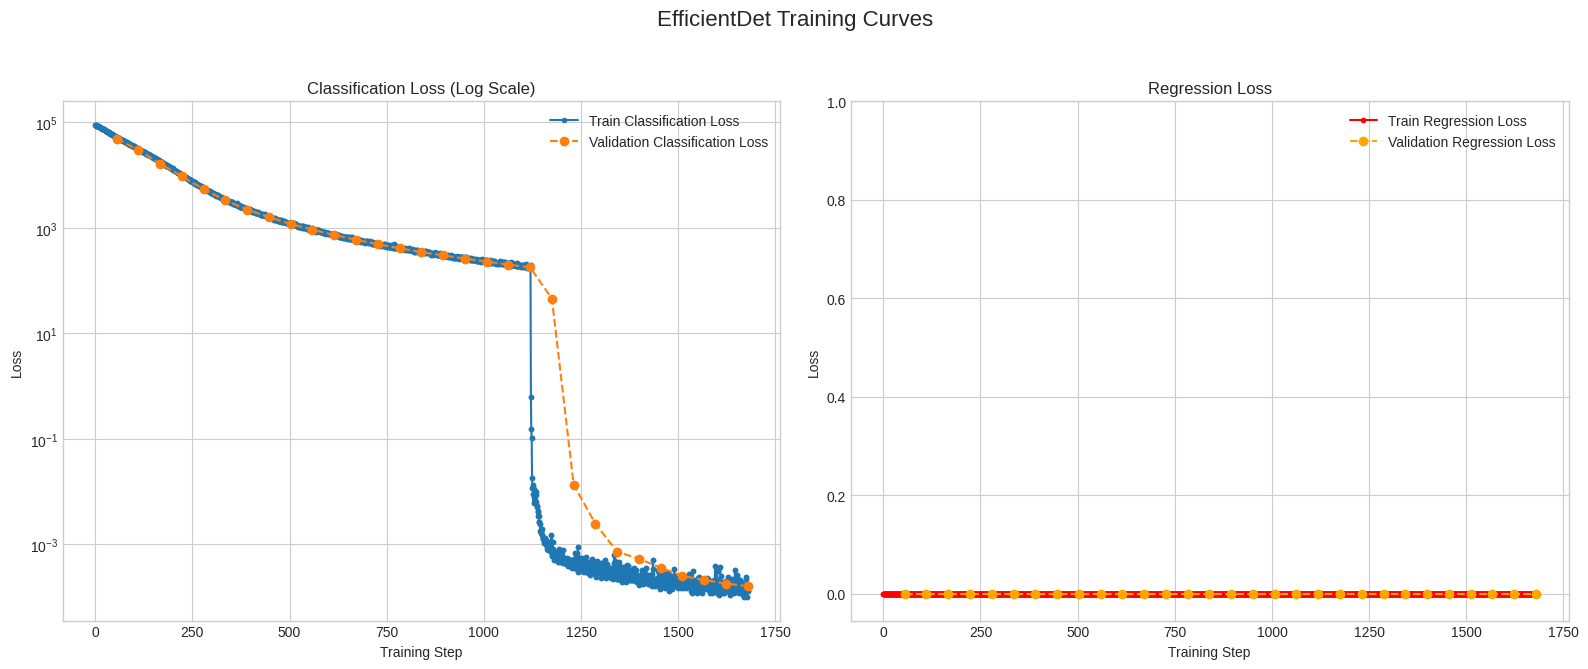

In [9]:
# Generate Graphs from Captured Log
# Load the log file content into the 'training_log_string' variable
with open('/content/training_log.txt', 'r') as f:
    training_log_string = f.read()

# Regular expressions to find the training and validation data
train_pattern = re.compile(r"Step: (\d+).*Cls loss: ([\d.e-]+).*Reg loss: ([\d.e-]+)")
val_pattern = re.compile(r"Val. Epoch: \d+/\d+. Classification loss: ([\d.e-]+). Regression loss: ([\d.e-]+)")

# Lists to store the extracted data
train_data = []
val_data = []
last_train_step = 0

# Check if the log string exists and is not empty
if 'training_log_string' in locals() and training_log_string:
    # Parse the log line by line
    for line in training_log_string.strip().split('\n'):
        train_match = train_pattern.search(line)
        val_match = val_pattern.search(line)

        if train_match:
            step = int(train_match.group(1))
            cls_loss = float(train_match.group(2).strip('.'))
            reg_loss = float(train_match.group(3).strip('.'))
            train_data.append({'step': step, 'cls_loss': cls_loss, 'reg_loss': reg_loss})
            last_train_step = step

        elif val_match:
            cls_loss = float(val_match.group(1).strip('.'))
            reg_loss = float(val_match.group(2).strip('.'))
            val_data.append({'step': last_train_step, 'cls_loss': cls_loss, 'reg_loss': reg_loss})

# Convert lists to Pandas DataFrames for easier plotting
train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(val_data)

# Plotting the Graph
if not train_df.empty and not val_df.empty:
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(16, 7))

    # Classification Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(train_df['step'], train_df['cls_loss'], label='Train Classification Loss', marker='.', linestyle='-')
    plt.plot(val_df['step'], val_df['cls_loss'], label='Validation Classification Loss', marker='o', linestyle='--')
    plt.yscale('log')
    plt.title('Classification Loss (Log Scale)')
    plt.xlabel('Training Step')
    plt.ylabel('Loss')
    plt.legend()

    # Regression Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(train_df['step'], train_df['reg_loss'], label='Train Regression Loss', color='red', marker='.')
    plt.plot(val_df['step'], val_df['reg_loss'], label='Validation Regression Loss', color='orange', marker='o', linestyle='--')
    plt.title('Regression Loss')
    plt.xlabel('Training Step')
    plt.ylabel('Loss')
    plt.legend()
    plt.ylim(top=max(1.0, train_df['reg_loss'].max() * 1.1)) # Dynamically adjust the y-axis

    plt.suptitle('EfficientDet Training Curves', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
else:
    print("ERROR: Could not extract training data from the captured log.")

Loading the trained EfficientDet model
'/content/Yet-Another-EfficientDet-Pytorch/logs/insect_project/efficientdet-d0_best.pth' not found.
Using last saved checkpoint as a fallback: /content/Yet-Another-EfficientDet-Pytorch/logs/insect_project/efficientdet-d0_29_1680.pth

Running inference on image: /content/datasets/insect_project/val/1180.jpg

Found 0 objects. This confirms the model's failure to learn localization


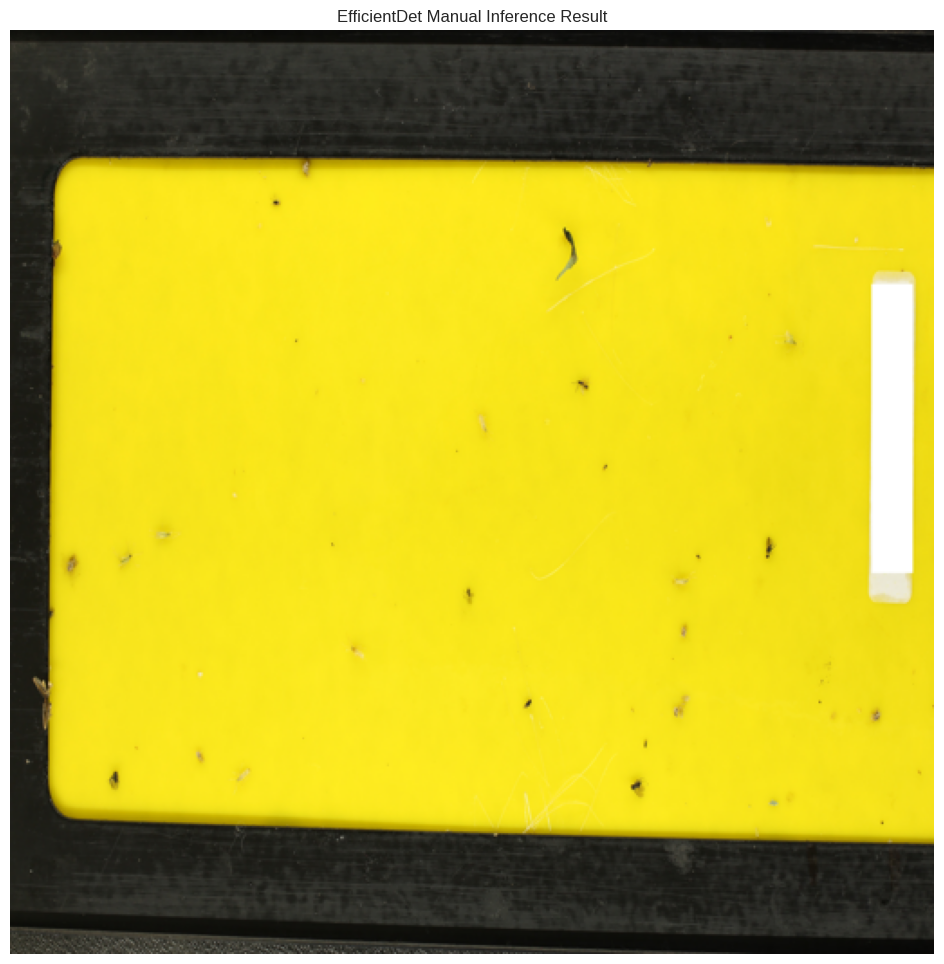

In [10]:
# Manual Inference and Visualization

# Find and Load the Trained Model
print("Loading the trained EfficientDet model")
# Define the directory where logs and checkpoints are saved
log_dir = '/content/Yet-Another-EfficientDet-Pytorch/logs/insect_project'
best_checkpoint_path = os.path.join(log_dir, 'efficientdet-d0_best.pth')

# Check if the 'best' checkpoint file exists, as it's only saved on validation improvement
if not os.path.exists(best_checkpoint_path):
    print(f"'{best_checkpoint_path}' not found.")
    # If 'best.pth' doesn't exist, find all other checkpoint files (.pth)
    all_checkpoints = glob(os.path.join(log_dir, '*.pth'))
    if all_checkpoints:
        # If other checkpoints are found, use the most recently created one as a fallback
        best_checkpoint_path = max(all_checkpoints, key=os.path.getctime)
        print(f"Using last saved checkpoint as a fallback: {best_checkpoint_path}")
    else:
        # If no checkpoints are found at all, print an error
        print("ERROR: No checkpoint files (.pth) were found in the log directory!")
        best_checkpoint_path = None
else:
    print(f"Using best checkpoint: {best_checkpoint_path}")

# Proceed only if a checkpoint was successfully found
if best_checkpoint_path:
    # Load the model structure and its trained weights
    model = EfficientDetBackbone(compound_coef=0, num_classes=3)
    # Use a try-except block to handle models saved with or without DataParallel wrapper
    try:
        model.load_state_dict(torch.load(best_checkpoint_path, map_location=torch.device('cpu')))
    except RuntimeError: # Handles the case where the model was saved with DataParallel
        state_dict = torch.load(best_checkpoint_path, map_location=torch.device('cpu'))
        from collections import OrderedDict
        new_state_dict = OrderedDict()
        for k, v in state_dict.items():
            name = k[7:]  # remove the `module.` prefix
            new_state_dict[name] = v
        model.load_state_dict(new_state_dict)

    # Set the model to evaluation mode and send it to the GPU if available
    model.eval()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)


    # Manually Prepare a Random Image
    val_dir = '/content/datasets/insect_project/val'
    random_val_image = random.choice(glob(os.path.join(val_dir, '*.jpg')))
    print(f"\nRunning inference on image: {random_val_image}")

    input_size = 512
    image = Image.open(random_val_image).convert('RGB')
    image_resized = image.resize((input_size, input_size))

    # Normalize the image pixels to be between 0 and 1
    image_np = np.array(image_resized, dtype=np.float32) / 255.0
    # Apply standard normalization (mean and std dev) with 32-bit floats
    mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
    std = np.array([0.229, 0.224, 0.225], dtype=np.float32)
    image_np = (image_np - mean) / std

    # Convert from (Height, Width, Channels) to (Channels, Height, Width) for PyTorch
    image_tensor = torch.from_numpy(image_np).permute(2, 0, 1)
    # Add batch dimension, send to device, and ensure it's a 32-bit float
    x = image_tensor.unsqueeze(0).to(device).float()


    # Run Inference and Post-processing
    with torch.no_grad(): # Disable gradient calculation for faster inference
        features, regression, classification, anchors = model(x)

        # Instantiate the necessary post-processing utility classes
        regress_boxes = BBoxTransform()
        clip_boxes = ClipBoxes()

        # Pass the created objects to the postprocess function to decode model output
        out = postprocess(x, anchors, regression, classification, regress_boxes, clip_boxes, threshold=0.2, iou_threshold=0.2)


    # Draw the Results on the Image
    img_display = np.array(image_resized)
    class_names = ['MR', 'NC', 'WF']

    # Check if any objects were detected above the threshold
    if out[0]['rois'].shape[0] > 0:
        # Loop through each detected object
        for j in range(len(out[0]['rois'])):
            (x1, y1, x2, y2) = out[0]['rois'][j].astype(np.int32)
            obj = class_names[out[0]['class_ids'][j]]
            score = float(out[0]['scores'][j])

            # Draw the bounding box and label on the image
            cv2.rectangle(img_display, (x1, y1), (x2, y2), (230, 11, 92), 2) # A bright pink color
            cv2.putText(img_display, f'{obj}: {score:.2f}', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (230, 11, 92), 2)
        print(f"\nFound {len(out[0]['rois'])} objects (if any).")
    else:
        print("\nFound 0 objects. This confirms the model's failure to learn localization")


    # Display the Final Image
    plt.figure(figsize=(12, 12))
    plt.imshow(img_display)
    plt.axis('off')
    plt.title("EfficientDet Manual Inference Result")
    plt.show()

else:
    print("\nSkipping inference because no valid checkpoint was found")

In [13]:
# Measuring Inference Speed (Corrected & Self-Contained)

# 1. Find and Load the Trained Model

print("Loading the trained EfficientDet model")
log_dir = '/content/Yet-Another-EfficientDet-Pytorch/logs/insect_project'
best_checkpoint_path = os.path.join(log_dir, 'efficientdet-d0_best.pth')

# Check if the 'best' checkpoint file, saved on validation improvement, exists
if not os.path.exists(best_checkpoint_path):
    print(f"'{best_checkpoint_path}' not found.")
    all_checkpoints = glob(os.path.join(log_dir, '*.pth'))
    if all_checkpoints:
        # If 'best.pth' doesn't exist, use the most recently created checkpoint as a fallback
        best_checkpoint_path = max(all_checkpoints, key=os.path.getctime)
        print(f"Falling back to the last saved checkpoint: {best_checkpoint_path}")
    else:
        # If no checkpoints are found at all, print an error and set the path to None
        print("ERROR: No checkpoint files (.pth) found in the log directory")
        best_checkpoint_path = None
else:
    print(f"Using best checkpoint: {best_checkpoint_path}")

# Proceed only if a valid checkpoint path was found
if best_checkpoint_path:
    # Load the model structure and weights
    model = EfficientDetBackbone(compound_coef=0, num_classes=3)
    try:
        # Standard method for loading model weights
        model.load_state_dict(torch.load(best_checkpoint_path, map_location=torch.device('cpu')))
    except RuntimeError:
        # Handles models that were saved using nn.DataParallel, which adds a 'module.' prefix
        state_dict = torch.load(best_checkpoint_path, map_location=torch.device('cpu'))
        from collections import OrderedDict
        new_state_dict = OrderedDict()
        for k, v in state_dict.items():
            name = k[7:]  # remove `module.` prefix
            new_state_dict[name] = v
        model.load_state_dict(new_state_dict)

    model.eval() # Set the model to evaluation mode (disables dropout, etc.)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device) # Move the model to the GPU if available
    print(f"Model loaded onto device: {device}")

    # 2. Manually Prepare a Sample Image
    val_dir = '/content/datasets/insect_project/val'
    img_path = random.choice(glob(os.path.join(val_dir, '*.jpg')))
    input_size = 512 # Corresponds to EfficientDet-D0

    # Open, convert to RGB, and resize the image
    image = Image.open(img_path).convert('RGB')
    image_resized = image.resize((input_size, input_size))

    # Convert to a numpy array and normalize pixel values to [0, 1]
    image_np = np.array(image_resized, dtype=np.float32) / 255.0

    # Apply standard ImageNet normalization
    mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
    std = np.array([0.229, 0.224, 0.225], dtype=np.float32)
    image_np = (image_np - mean) / std

    # Convert from (Height, Width, Channels) to the (Channels, Height, Width) format required by PyTorch
    image_tensor = torch.from_numpy(image_np).permute(2, 0, 1)

    # Add a batch dimension, send to the target device, and ensure it's a 32-bit float
    x = image_tensor.unsqueeze(0).to(device).float()

    # 3. Run the Speed Test
    # Warm-up run: the first inference call is always slower due to setup and caching
    print("\nRunning Warm-up Inference")
    with torch.no_grad(): # Disable gradient calculation for efficiency
        _ = model(x)

    # Define the number of inferences for the test before using the variable
    num_inferences = 50
    print(f"Running Speed Test ({num_inferences} inferences)")

    # Measurement loop
    start_time = time.time()
    with torch.no_grad():
        for _ in range(num_inferences):
            _ = model(x)
    end_time = time.time()

    # Calculation
    total_time = end_time - start_time
    avg_time_per_inference = total_time / num_inferences
    fps = 1 / avg_time_per_inference

    # 4. Print the Results
    print("\nInference Speed (EfficientDet)")
    print(f"Device used: {device}")
    print(f"Average time per image: {avg_time_per_inference * 1000:.2f} ms")
    print(f"Frames Per Second (FPS): {fps:.2f}")

else:
    print("\nSkipping speed test because no valid checkpoint was found")

Loading the trained EfficientDet model
'/content/Yet-Another-EfficientDet-Pytorch/logs/insect_project/efficientdet-d0_best.pth' not found.
Falling back to the last saved checkpoint: /content/Yet-Another-EfficientDet-Pytorch/logs/insect_project/efficientdet-d0_29_1680.pth
Model loaded onto device: cuda:0

Running Warm-up Inference
Running Speed Test (50 inferences)

Inference Speed (EfficientDet)
Device used: cuda:0
Average time per image: 42.47 ms
Frames Per Second (FPS): 23.55
